In [1]:
import os
import sys
working_dir = os.path.join(os.getcwd().split("Text2BGAudio")[0],'Text2BGAudio')
sys.path.append(working_dir)
os.chdir(working_dir)
from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter,defaultdict
from tqdm import tqdm

from Dataset_Creation import audio_dataset
from torch.utils.data import DataLoader
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")


c:\Users\amitmils\Documents\Repo\Text2BGAudio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
data_path = r"_Data\Music\Music Data New\music_dataset_fixed_Music Data New_tr3141_val390_te398.pt"
clap_model_path = r"CLAP\models\new_fixed\clap_fine_tunned_Fixeed_BatchSize_32_LR_1e-05_Epochs_400_VAL_LOSS_26.47.pt"

Text(0.5, 1.0, 'Train and Validation Loss')

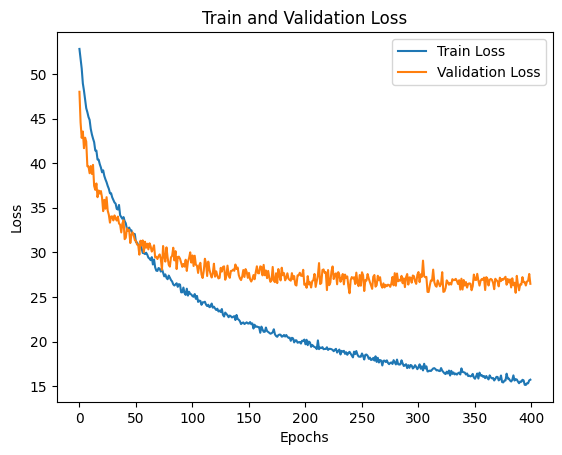

In [10]:
model_name = "laion/larger_clap_music"
clap_model = torch.load(clap_model_path,weights_only=False,map_location=DEVICE)
model = ClapModel.from_pretrained(model_name).to(DEVICE)
processor = ClapProcessor.from_pretrained(model_name)
# model.load_state_dict(clap_model['model_state_dict'])
plt.plot(range(len(clap_model['train_Loss_Per_Epoch'])),clap_model['train_Loss_Per_Epoch'],label='Train Loss')
plt.plot(range(len(clap_model['val_Loss_Per_Epoch'])),clap_model['val_Loss_Per_Epoch'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')


In [5]:
train_data, val_data, test_data = list(torch.load(data_path, weights_only=False).values())


In [7]:
test_dataset = audio_dataset.AudioDataset(test_data)
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


In [ ]:
correct = 0
total_labels = list()
with torch.no_grad():
    for i,batch in tqdm(enumerate(test_data_loader),desc="Batches",total=len(test_data_loader)):
        audio = batch[0]
        labels = list(batch[1])
        total_labels.extend(labels) #save this for later to get counter
        unique_labels = list(set(labels))
        inputs = processor(
            text=unique_labels,
            audios=audio.numpy(),
            return_tensors="pt",
            sampling_rate=48000,
            padding=True,
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = model(**inputs)
        text_embeds = outputs.text_embeds
        audio_embeds = outputs.audio_embeds
        
        audio_embeddings = F.normalize(audio_embeds, p=2, dim=1)
        text_embeddings = F.normalize(text_embeds, p=2, dim=1)
        similarity_matrix = torch.mm(text_embeddings,audio_embeddings.t())
        binary_matrix = torch.zeros_like(similarity_matrix)
        topk_indices = torch.topk(similarity_matrix, k=1, dim=0).indices
        binary_matrix[topk_indices, torch.arange(similarity_matrix.size(1)).unsqueeze(0).expand(2, -1)] = 1
        gt_matrix = torch.zeros(similarity_matrix.shape)
        for col in range(len(audio_embeddings)):
            gt_matrix[unique_labels.index(labels[col]),col] = 1
        correct += torch.sum((gt_matrix.cpu() == 1) & (binary_matrix.cpu() == 1))
print(f'Accuracy : {correct/len(test_data_loader.dataset)}')





Batches: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

Accuracy : 0.1306532621383667


: 

In [ ]:
label_counts = Counter(total_labels)
# Print the counts
print(label_counts)

Counter({'joy': 95, 'love': 84, 'sadness': 72, 'anger': 60, 'fear': 52, 'surprise': 42})
